## Example -- IEA Wind 740-10-MW

**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `optiwindnet` to route the collector system cables for the two wind power plants presented in the report above.

In [1]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, MetaHeuristic, MILP, ModelOptions

### Additional design parameters

In [2]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]
cables = [(capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]

### Load layouts from files

In [3]:
wfn_reg = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Regular_System.yaml', cables=cables)

In [4]:
wfn_irr = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Irregular_System.yaml', cables=cables)

<Axes: >

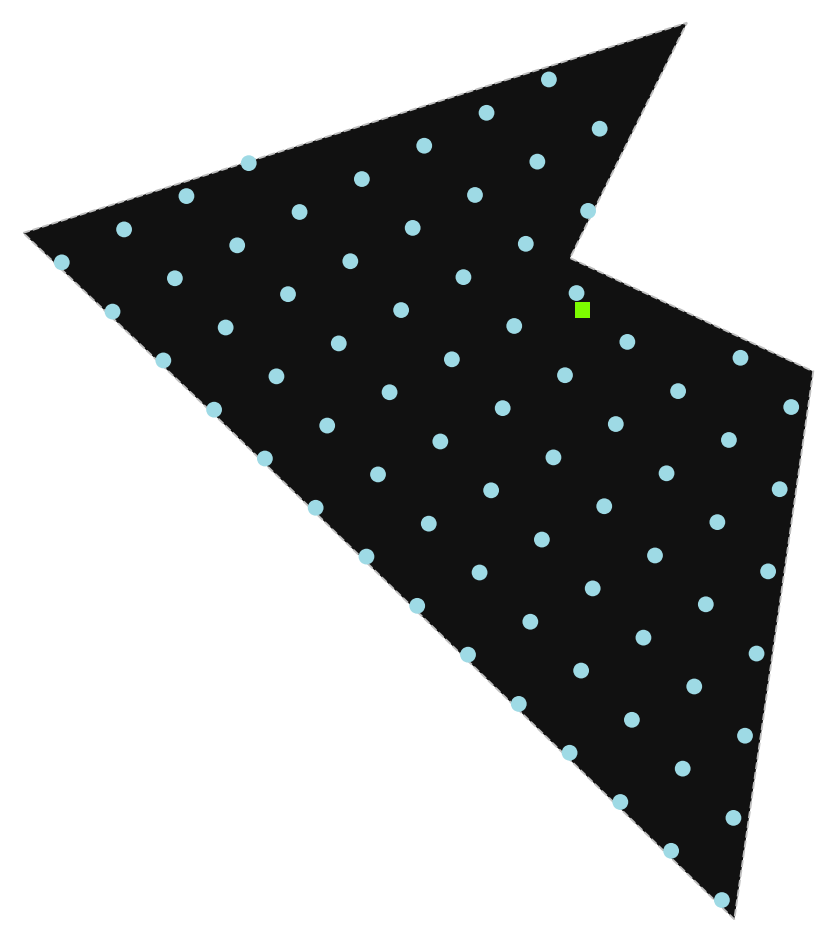

In [5]:
wfn_reg.plot_location()

<Axes: >

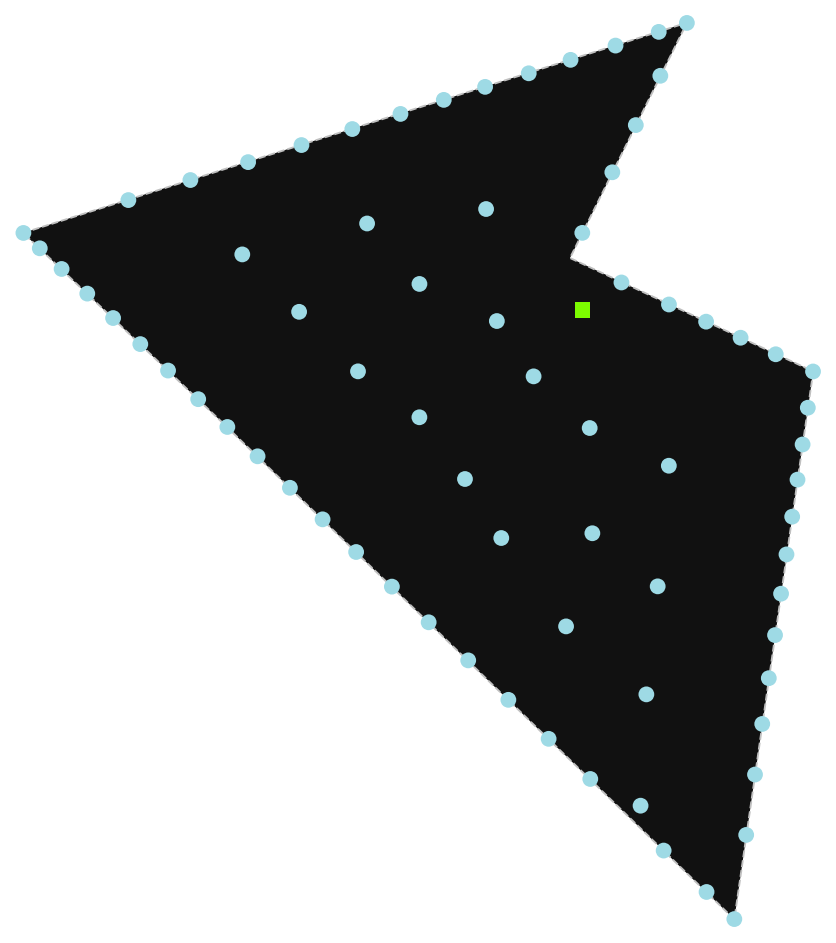

In [6]:
wfn_irr.plot_location()

### Choose solver

In [7]:
router_warmstart = MetaHeuristic(time_limit=5, verbose=True)

solver_options=dict(
        num_workers = 8,
    )

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_main = MILP(solver_name='ortools', time_limit=300, mip_gap=0.005, solver_options=solver_options, model_options=model_options, verbose=True)

### Regular layout

In [8]:
res_reg_warmup = wfn_reg.optimize(router=router_warmstart)

Check the total length of the warm-start solution:

In [ ]:
wfn_reg.length()

139656.4789599965

Optimize with main router

In [10]:
res_reg = wfn_reg.optimize(router=router_main)

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xe74836c5ec0426db)
#Variables: 1'540 (#bools: 7

In [11]:
wfn_reg.length()

139555.82805078843

In [ ]:
wfn_reg.cost()

40622411.15706752

<Axes: >

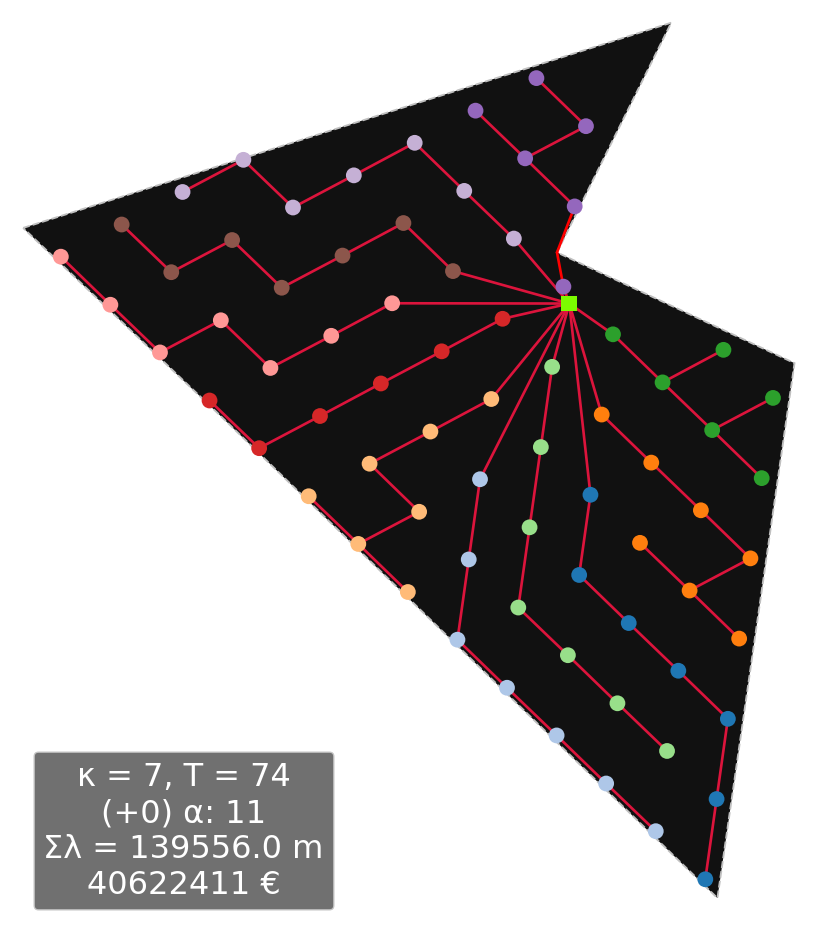

In [13]:
wfn_reg.plot()

### Irregular layout

In [14]:
res_irr_warmup = wfn_irr.optimize(router=router_warmstart)

Check the total length of the warm-start solution:

In [ ]:
wfn_irr.length()

136472.2480500915

Optimize with main router

In [16]:
res_irr = wfn_irr.optimize(router=router_main)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0xe6e149b34fc3a1a4)
#Variables: 1'192 (#bools: 596 in floating point objective)
  - 596 Booleans in [0,1]
  - 522 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 419 (#literals: 1'216)
#kLinear1: 1'192 (#enforced: 1'192)
#kLinear2: 4
#kLinear3: 5
#kLinearN: 216 (#terms: 2'957)

Starting presolve at 0.00s
[Scaling] Floating point objective has 596 terms with magnitude in [539.378, 15073.7] average = 3460.13
[Scaling] Objective coefficient relative error: 4.51281e-10
[Scaling] Objective worst-case absolute error: 7.28067e-05
[Scaling] Objective scaling factor: 1.04858e+06
  3.79e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.27e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  5.50e-05s  0.00e+00d  [operations_research::sat::CpModelPre

In [17]:
wfn_irr.length()

134807.7634895362

In [ ]:
wfn_irr.cost()

43091183.191651106

<Axes: >

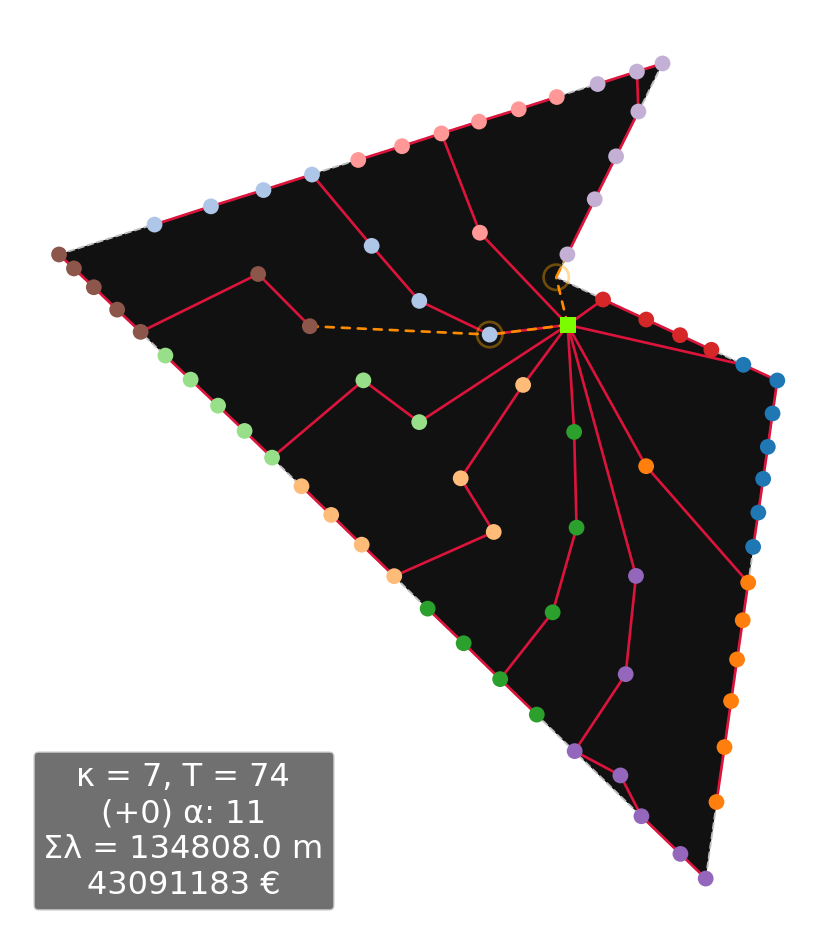

In [19]:
wfn_irr.plot()

### Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [20]:
network_reg = wfn_reg.get_network()

In [21]:
network_cable_reg = np.column_stack((network_reg['src'], network_reg['tgt'], network_reg['cable']))
print(network_cable_reg)


[[72 71  0]
 [73 66  0]
 [67 57  2]
 [67 68  1]
 [68 69  1]
 [45 -1  2]
 [45 44  1]
 [65 66  1]
 [65 80  1]
 [18 19  0]
 [26 27  1]
 [26 19  0]
 [44 31  0]
 [44 43  0]
 [33 32  2]
 [33 -1  2]
 [70 61  0]
 [70 63  0]
 [61 69  0]
 [ 5  4  0]
 [ 5 10  0]
 [10 11  1]
 [51 62  0]
 [51 60  1]
 [62 53  0]
 [ 8  9  0]
 [ 8  3  0]
 [ 9 16  0]
 [40 29  0]
 [41 52  0]
 [41 54  0]
 [14  7  1]
 [14 15  1]
 [22 13  0]
 [39 52  1]
 [39 50  1]
 [23 15  2]
 [23 -1  2]
 [34 46  2]
 [34 24  1]
 [57 -1  2]
 [66 71  0]
 [53 64  0]
 [19 28  0]
 [25 17  2]
 [25 -1  2]
 [ 6  7  0]
 [ 6  2  0]
 [11 17  1]
 [16 24  1]
 [-1 56  2]
 [-1 47  2]
 [-1 46  2]
 [-1 35  2]
 [-1 49  2]
 [-1 58  2]
 [27 36  1]
 [36 35  2]
 [48 37  1]
 [48 47  1]
 [12 13  0]
 [42 31  0]
 [59 58  2]
 [59 60  1]
 [38 29  0]
 [38 37  0]
 [20 13  0]
 [20 21  1]
 [49 50  2]
 [21 32  1]
 [31 30  0]
 [ 0  2  0]
 [ 1  4  0]
 [56 80  1]
 [54 55  0]]


In [22]:
network_irr = wfn_irr.get_network()
network_cable_irr = np.column_stack((network_irr['src'], network_irr['tgt'], network_irr['cable']))
print(network_cable_irr)

[[15 21  0]
 [15  3  0]
 [21 66  0]
 [58 65  0]
 [58 61  1]
 [65 48  0]
 [65 47  0]
 [16 29  1]
 [16 17  0]
 [29 53  1]
 [36 62  0]
 [36 35  0]
 [62 69  1]
 [42  8  1]
 [42 25  2]
 [37 51  1]
 [37 20  1]
 [70 67  2]
 [70 -1  2]
 [ 5  9  0]
 [ 5 32  0]
 [10 24  0]
 [40 55  0]
 [40 57  0]
 [41 -1  2]
 [41 51  2]
 [34  1  0]
 [34 20  0]
 [49 54  2]
 [49 -1  2]
 [53 28  2]
 [46 50  0]
 [46 44  0]
 [22 67  1]
 [22 44  1]
 [23 43  0]
 [43  7  0]
 [31 26  0]
 [31 56  0]
 [56 30  1]
 [68 14  1]
 [68 73  2]
 [13 26  0]
 [-1 60  2]
 [-1 55  1]
 [-1 39  2]
 [-1 28  2]
 [-1 33  2]
 [-1 25  2]
 [-1 80  2]
 [-1 81  2]
 [71 64  2]
 [71 81  2]
 [64 61  1]
 [27 52  0]
 [27 38  0]
 [52 59  0]
 [60 59  2]
 [ 3 12  1]
 [50  0  0]
 [ 9 19  0]
 [11 18  0]
 [45 33  2]
 [45 12  1]
 [ 2  8  1]
 [ 2  7  0]
 [73 80  2]
 [69 63  1]
 [57 72  0]
 [39 63  2]
 [32 14  1]
 [18 59  0]
 [17 24  0]
 [ 6 35  0]
 [54 30  1]
 [20  4  0]]


Mapping of contour/detour node to the index of its VertexC coordinate :

In [ ]:
if wfn_reg.G.graph.get('C') or wfn_reg.G.graph.get('D'):
    R, T, B = (wfn_reg.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_reg.G.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 76}


Mapping of contour/detour node to the index of its VertexC coordinate :

In [ ]:
if wfn_irr.G.graph.get('C') or wfn_irr.G.graph.get('D'):
    R, T, B = (wfn_irr.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_irr.G.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 28, 81: 76}
